
# Housing Price Model 




## 0. Setup

In [3]:

# Avoid seaborn per instructions; use only pandas/matplotlib/sklearn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib
from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Display options
pd.set_option('display.max_columns', 100)


## 1. Load Data

In [5]:

CSV_PATH_CANDIDATES = [
    'housing.csv',
    './housing.csv',
    '../housing.csv',
    '/Users/rohilzalke/Desktop/DataSet/housing.csv'  # your local path from the earlier notebook
]

csv_path = None
for p in CSV_PATH_CANDIDATES:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("Could not find 'housing.csv'. Place it in the notebook folder or update CSV_PATH_CANDIDATES.")

df = pd.read_csv(csv_path)
df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 2. Quick Data Health Check

In [7]:

print("Shape:", df.shape)
print("\nColumn info:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nBasic stats (numeric):")
display(df.describe())


Shape: (20640, 10)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None

Missing values per column:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
med

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## 3. Exploratory Data Analysis (EDA)

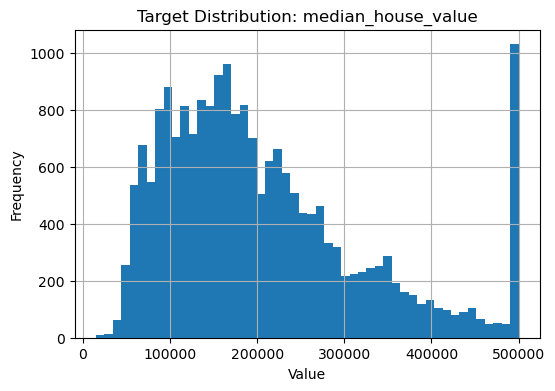

<Figure size 600x400 with 0 Axes>

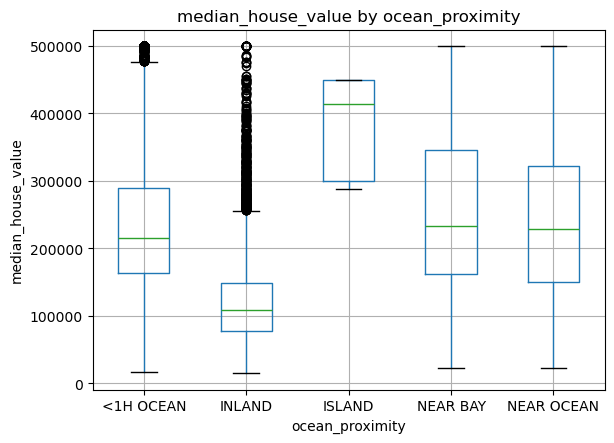

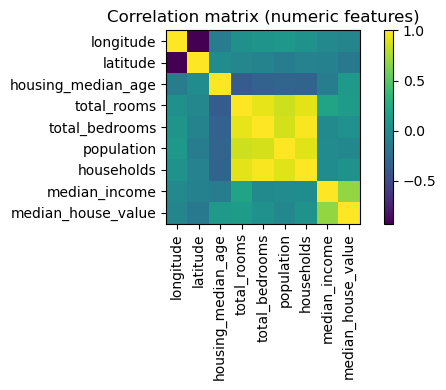

In [9]:

# Target distribution
plt.figure(figsize=(6,4))
df['median_house_value'].hist(bins=50)
plt.title("Target Distribution: median_house_value")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Group-wise target by ocean_proximity
if 'ocean_proximity' in df.columns:
    plt.figure(figsize=(6,4))
    df.boxplot(column='median_house_value', by='ocean_proximity')
    plt.title("median_house_value by ocean_proximity")
    plt.suptitle("")
    plt.xlabel("ocean_proximity")
    plt.ylabel("median_house_value")
    plt.show()

# Correlations (numeric only)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr()
plt.figure(figsize=(6,4))
plt.imshow(corr, interpolation='nearest')
plt.title("Correlation matrix (numeric features)")
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.tight_layout()
plt.show()


## 4. Outlier Handling 

In [11]:

def cap_outliers_symmetric(series, factor=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    # For non-negative economic counts, avoid capping below min
    lower = max(lower, series.min())
    capped = series.clip(lower=lower, upper=upper)
    return capped

# Choose columns to consider for gentle capping (excluding the target for now)
candidate_caps = [c for c in numeric_cols if c != 'median_house_value']
df_cap = df.copy()
for c in candidate_caps:
    df_cap[c] = cap_outliers_symmetric(df_cap[c], factor=1.5)

print("Applied optional outlier capping to numeric predictors (not target).")
for c in candidate_caps:
    print(f"Skewness before outliler capping for {c}: {df[c].skew():.2f}")
    print(f"Skewness after outliler capping for {c}: {df_cap[c].skew():.2f}\n")


Applied optional outlier capping to numeric predictors (not target).
Skewness before outliler capping for longitude: -0.30
Skewness after outliler capping for longitude: -0.30

Skewness before outliler capping for latitude: 0.47
Skewness after outliler capping for latitude: 0.47

Skewness before outliler capping for housing_median_age: 0.06
Skewness after outliler capping for housing_median_age: 0.06

Skewness before outliler capping for total_rooms: 4.15
Skewness after outliler capping for total_rooms: 0.84

Skewness before outliler capping for total_bedrooms: 3.46
Skewness after outliler capping for total_bedrooms: 0.87

Skewness before outliler capping for population: 4.94
Skewness after outliler capping for population: 0.84

Skewness before outliler capping for households: 3.41
Skewness after outliler capping for households: 0.84

Skewness before outliler capping for median_income: 1.65
Skewness after outliler capping for median_income: 0.74



## 5. Statistical Analysis

In [13]:
near_bay = df_cap[df_cap['ocean_proximity'] == 'NEAR BAY']['median_house_value']
inland = df_cap[df_cap['ocean_proximity'] == 'INLAND']['median_house_value']
ttest_ind(near_bay, inland)

TtestResult(statistic=63.76872576298976, pvalue=0.0, df=8839.0)

##### t-statistics (63.77) indicates that difference in means between coastal NEAR BAY and INLAND house prices is extremely significant. The prices of houses near by ocean is higher than the houses near bay.

##### p-value (0.0): A p-value of 0.0 means there’s less than a 0.0001% chance this difference is due to random noise
##### df=8839.0 tells us: There are roughly 8841 total independent observations (Near Bay + inland)

##### The t-statistic alone doesn’t tell you how much more expensive coastal homes are. Hence we will be using Cohen’s d:

In [15]:
import numpy as np
near_bay = df_cap[df_cap['ocean_proximity'] == 'NEAR BAY']['median_house_value']
inland = df_cap[df_cap['ocean_proximity'] == 'INLAND']['median_house_value']
n1, n2 = len(near_bay), len(inland)
s1, s2 = np.std(near_bay, ddof=1), np.std(inland, ddof=1)
pooled_std = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1 + n2 - 2))
cohens_d = (near_bay.mean() - inland.mean()) / pooled_std
print(f"Cohen's d: {cohens_d:.2f}")

Cohen's d: 1.55


##### The Cohen's d test signifies that near bay houses are much more expensive than inland houses.

##### ANOVA: For multiple group comparision

In [18]:
group_list = []

for i in df_cap['ocean_proximity'].unique():
    group_list.append(df_cap[df_cap['ocean_proximity']==i]['median_house_value'])

f_stats, p_value = f_oneway(*group_list)
print(f"F-statistics: {f_stats:.2f} & p-value: {p_value:.2f}")

F-statistics: 1612.14 & p-value: 0.00


###### p-value: 0.00 signifies that the null hypothesis (all means are equal) is rejected. Hence At least one ocean proximity category has a significantly different mean house value compared to others.

###### F-statistics: 1612.14 (Large) indicates a strong evidence that at least one group’s mean is truly different

#### To find which specific groups differ, we will use Post-Hoc Tukey Test

In [21]:
tukey = pairwise_tukeyhsd(
    endog = df_cap['median_house_value'],
    groups = df_cap['ocean_proximity'],
    alpha=0.05
)
print(tukey.summary())

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1    group2     meandiff   p-adj     lower        upper     reject
-------------------------------------------------------------------------
<1H OCEAN     INLAND -115278.8935    0.0 -119727.9273 -110829.8596   True
<1H OCEAN     ISLAND  140355.7145 0.0158   17424.7149  263286.7142   True
<1H OCEAN   NEAR BAY   19128.0263    0.0   12705.8987   25550.1539   True
<1H OCEAN NEAR OCEAN     9349.692 0.0002    3293.4581   15405.9258   True
   INLAND     ISLAND   255634.608    0.0  132690.3424  378578.8736   True
   INLAND   NEAR BAY  134406.9198    0.0  127735.6768  141078.1628   True
   INLAND NEAR OCEAN  124628.5854    0.0  118308.7968  130948.3741   True
   ISLAND   NEAR BAY -121227.6882 0.0557 -244259.1568    1803.7804  False
   ISLAND NEAR OCEAN -131006.0226 0.0302 -254018.9345   -7993.1106   True
 NEAR BAY NEAR OCEAN   -9778.3344  0.006  -17613.4827    -1943.186   True
--------------------------------------

#### Kruskal-Wallis (Non-Parametric) Test

In [23]:
from scipy.stats import kruskal
group_list1 = []

for i in df_cap['ocean_proximity'].unique():
    group_list1.append(df_cap[df_cap['ocean_proximity']==i]['median_house_value'])

h_stat, p_value = kruskal(*group_list1)
print(f"H-statistic: {h_stat:.2f}, p-value: {p_value:.4f}")

H-statistic: 6634.56, p-value: 0.0000


##### H-statistic = 6634.56. 
##### H-statistic measures the differences between group rankings.
##### A large H → The groups differ a lot in their median values.
##### p-value: 0.00 -> We reject the null hypothesis. At least one ocean proximity category has a different median house value.

##### Post-Hoc Test (Dunn’s Test)

In [26]:
import scikit_posthocs as sp
near_bay1 = df_cap[df_cap['ocean_proximity']=='NEAR BAY']['median_house_value']
H_OCEAN1 = df_cap[df_cap['ocean_proximity']=='<1H OCEAN']['median_house_value']
inland1 = df_cap[df_cap['ocean_proximity']=='INLAND']['median_house_value']
near_ocean1 = df_cap[df_cap['ocean_proximity']=='NEAR OCEAN']['median_house_value']
island1 = df_cap[df_cap['ocean_proximity']=='ISLAND']['median_house_value']

data = pd.DataFrame({
    'price': pd.concat([near_bay1, H_OCEAN1, inland1, near_ocean1, island1]),
    'group': ['NEAR BAY']*len(near_bay1) + ['<1H OCEAN']*len(H_OCEAN1) + ['INLAND']*len(inland1) + ['NEAR OCEAN']*len(near_ocean1) + ['ISLAND']*len(island1)
})

dunn_results = sp.posthoc_dunn(data, val_col='price', group_col='group', p_adjust='bonferroni')
print(dunn_results)

            <1H OCEAN    INLAND    ISLAND  NEAR BAY  NEAR OCEAN
<1H OCEAN    1.000000  0.000000  0.338968  0.005787    1.000000
INLAND       0.000000  1.000000  0.000015  0.000000    0.000000
ISLAND       0.338968  0.000015  1.000000  0.523886    0.338018
NEAR BAY     0.005787  0.000000  0.523886  1.000000    0.042270
NEAR OCEAN   1.000000  0.000000  0.338018  0.042270    1.000000


## 6. Feature Engineering

In [28]:

df_fe = df_cap.copy()

# Common engineered features for this dataset
if all(col in df_fe.columns for col in ['total_rooms','households']):
    df_fe['rooms_per_household'] = df_fe['total_rooms'] / (df_fe['households'].replace(0, np.nan))
if all(col in df_fe.columns for col in ['total_bedrooms','total_rooms']):
    df_fe['bedrooms_per_room'] = df_fe['total_bedrooms'] / (df_fe['total_rooms'].replace(0, np.nan))
if all(col in df_fe.columns for col in ['population','households']):
    df_fe['population_per_household'] = df_fe['population'] / (df_fe['households'].replace(0, np.nan))

# Replace inf/NaN from divisions
df_fe = df_fe.replace([np.inf, -np.inf], np.nan)
df_fe = df_fe.fillna({
    'rooms_per_household': df_fe['rooms_per_household'].median() if 'rooms_per_household' in df_fe else np.nan,
    'bedrooms_per_room': df_fe['bedrooms_per_room'].median() if 'bedrooms_per_room' in df_fe else np.nan,
    'population_per_household': df_fe['population_per_household'].median() if 'population_per_household' in df_fe else np.nan
})

df_fe.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.000,129.0,322.0,126.0,8.013025,452600.0,NEAR BAY,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,5698.375,1106.0,2401.0,1092.5,8.013025,358500.0,NEAR BAY,5.215904,0.194090,2.197712
2,-122.24,37.85,52.0,1467.000,190.0,496.0,177.0,7.257400,352100.0,NEAR BAY,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.000,235.0,558.0,219.0,5.643100,341300.0,NEAR BAY,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.000,280.0,565.0,259.0,3.846200,342200.0,NEAR BAY,6.281853,0.172096,2.181467


## 7. Train/Test Split (Stratified by Income Category)

In [30]:

df_split = df_fe.copy()

# Create income categories for stratified split (cap at 5 to avoid tiny bins)
train_set, test_set = train_test_split(df_split, test_size=0.2, random_state=42)

train_set.shape, test_set.shape


((16512, 13), (4128, 13))

## 8. Preprocessing Pipelines

In [32]:

target = 'median_house_value'

X_train = train_set.drop(columns=[target])
y_train = train_set[target].copy()
X_test = test_set.drop(columns=[target])
y_test = test_set[target].copy()

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

log_target = False  # flip to True to try log-target regression

def log1p_safe(y):
    return np.log1p(y)

def expm1_safe(y):
    return np.expm1(y)

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Fill missing categories with the most common value
    ('scaler', StandardScaler())  # Standardize (mean=0, std=1)
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Fill missing categories with the most common value
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Convert text into 0/1 columns
])

preprocess = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

preprocess


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'rooms_per_household', 'bedrooms_per_room',
                                  'population_per_household']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['ocean_proximity'])])

## 9. Baseline and Linear Models (with Cross-Validation)

In [34]:

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Baseline: Dummy (median predictor)
baseline = Pipeline(steps=[('preprocess', preprocess),
                          ('model', DummyRegressor(strategy='median'))])
lr = Pipeline(steps=[('preprocess', preprocess),
                    ('model', LinearRegression())])
ridge = Pipeline(steps=[('preprocess', preprocess),
                       ('model', Ridge())])
lasso = Pipeline(steps=[('preprocess', preprocess),
                       ('model', Lasso(max_iter=20000))])

scoring_mae = 'neg_mean_absolute_error'
scoring_mse = 'neg_mean_squared_error'

def cv_scores(pipeline, X, y, cv=5):
    scores_mae = cross_val_score(pipeline, X, y, scoring=scoring_mae, cv=cv)
    scores_mse = cross_val_score(pipeline, X, y, scoring=scoring_mse, cv=cv)
    mae = -scores_mae.mean()
    rmse_score = np.sqrt(-scores_mse.mean())
    return mae, rmse_score

models = {
    'Baseline(Median)': baseline,
    'LinearRegression': lr,
    'Ridge': ridge,
    'Lasso': lasso
}

results = []
for name, pipe in models.items():
    mae, rmse_cv = cv_scores(pipe, X_train, y_train, cv=5)
    results.append((name, mae, rmse_cv))

results_df = pd.DataFrame(results, columns=['Model','CV_MAE','CV_RMSE']).sort_values('CV_RMSE')
results_df


,Model,CV_MAE,CV_RMSE
2,Ridge,48679.164868,65791.398132
1,LinearRegression,48680.218958,65792.313913
3,Lasso,48680.274297,65792.356571
0,Baseline(Median),88601.202731,118794.478779


## 10. Hyperparameter Tuning for Ridge/Lasso

In [36]:

param_grid_ridge = {'model__alpha': np.logspace(-3, 3, 13)}
param_grid_lasso = {'model__alpha': np.logspace(-3, 1, 9)}

ridge_gs = GridSearchCV(ridge, param_grid_ridge, scoring=scoring_mse, cv=5, n_jobs=-1)
lasso_gs = GridSearchCV(lasso, param_grid_lasso, scoring=scoring_mse, cv=5, n_jobs=-1)

ridge_gs.fit(X_train, y_train)
lasso_gs.fit(X_train, y_train)

ridge_best_rmse = np.sqrt(-ridge_gs.best_score_)
lasso_best_rmse = np.sqrt(-lasso_gs.best_score_)

print("Best Ridge alpha:", ridge_gs.best_params_)
print("Best Ridge CV RMSE:", ridge_best_rmse)

print("Best Lasso alpha:", lasso_gs.best_params_)
print("Best Lasso CV RMSE:", lasso_best_rmse)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.593e+12, tolerance: 1.757e+10
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.624e+12, tolerance: 1.779e+10
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.624e+12, toler

Best Ridge alpha: {'model__alpha': 1.0}
Best Ridge CV RMSE: 65791.39813193673
Best Lasso alpha: {'model__alpha': 0.03162277660168379}
Best Lasso CV RMSE: 65792.31270358128


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.197e+12, tolerance: 2.207e+10
  model = cd_fast.enet_coordinate_descent(


## 11. Tree-Based Models (Often Stronger for Tabular Data)

In [38]:

rf = Pipeline(steps=[('preprocess', preprocess),
                    ('model', RandomForestRegressor(
                        n_estimators=300, random_state=42, n_jobs=-1,
                        max_features='sqrt', min_samples_leaf=1
                    ))])

gb = Pipeline(steps=[('preprocess', preprocess),
                     ('model', GradientBoostingRegressor(random_state=42))])

rf_mae, rf_rmse = cv_scores(rf, X_train, y_train, cv=5)
gb_mae, gb_rmse = cv_scores(gb, X_train, y_train, cv=5)

pd.DataFrame([
    ('RandomForest', rf_mae, rf_rmse),
    ('GradientBoosting', gb_mae, gb_rmse)
], columns=['Model','CV_MAE','CV_RMSE']).sort_values('CV_RMSE')


,Model,CV_MAE,CV_RMSE
0,RandomForest,33346.881610,49625.347936
1,GradientBoosting,36915.628421,53220.710296


## 11. Fit Best Model and Evaluate on Test Set

Test MAE: 37,042.64
Test RMSE: 54,332.44
Test R^2: 0.775


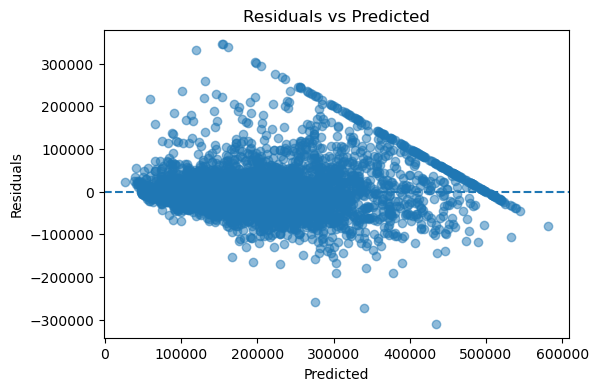

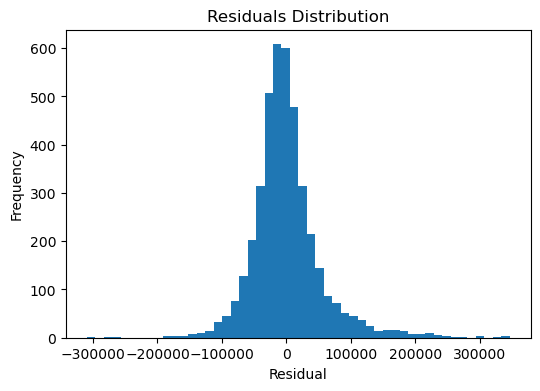

In [40]:

# Choose the best performing model based on CV RMSE from above; as a starting point, try GradientBoosting
best_model = gb
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = rmse(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print(f"Test MAE: {mae_test:,.2f}")
print(f"Test RMSE: {rmse_test:,.2f}")
print(f"Test R^2: {r2_test:.3f}")

# Residual diagnostics
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


## 13. Predictions on the Training & Test Set

In [42]:
ridge_best = ridge_gs.best_estimator_
lasso_best = lasso_gs.best_estimator_

y_predict_ridge = ridge_best.predict(X_test)
y_predict_lasso = lasso_best.predict(X_test)

## 14. Compare Actual vs Predicted

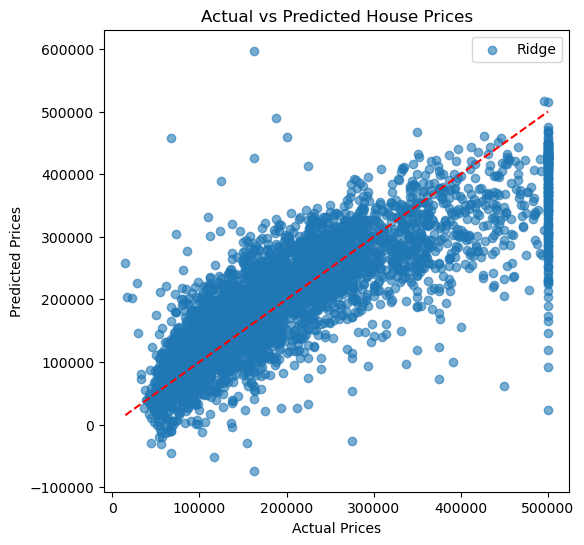

In [44]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_predict_ridge, alpha=0.6, label="Ridge")
#plt.scatter(y_test, y_predict_lasso, alpha=0.6, label="Lasso")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # ideal line
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.title("Actual vs Predicted House Prices")
plt.show()

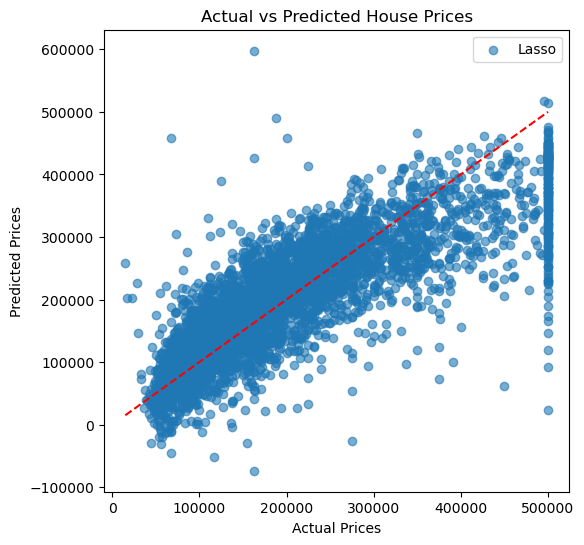

In [45]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_predict_lasso, alpha=0.6, label="Lasso")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # ideal line
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.title("Actual vs Predicted House Prices")
plt.show()

## 13. Save the Trained Pipeline

In [47]:

joblib.dump(best_model, 'housing_price_pipeline.joblib')
print("Saved pipeline to 'housing_price_pipeline.joblib'")


Saved pipeline to 'housing_price_pipeline.joblib'
